# Multi Greek Hedging

In [46]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np

from utils.process import process_options,process_underlying,process_rf
from utils.greeks import delta, gamma, vega, theta, rho
from utils.implied_volatility import implied_vol_b76
from tqdm import tqdm

tqdm.pandas()


In [47]:
option_data = pd.read_csv("../data/SPYOPT_processed.csv",parse_dates=True)
underlying = pd.read_csv("../data/SPYFUT_processed.csv",parse_dates=True).rename(columns={'close': 'futures_close'})
rf_rate = pd.read_csv("../data/RFRate.csv", parse_dates=True).rename(columns={'rate': 'rf_rate'})

In [48]:
all_data = pd.merge(option_data, 
                    underlying[['ts_event', 'expiration_date', 'futures_close']], 
                    on=['ts_event', 'expiration_date'], 
                    how='left')

all_data = pd.merge(all_data, 
                    rf_rate[['ts_event', 'rf_rate']], 
                    on='ts_event', 
                    how='left')

all_data['rf_rate'] = all_data['rf_rate'].ffill().bfill()
all_data['rf_rate'] = 12 *np.log(1 + all_data['rf_rate']/1200)

all_data['ts_event'] = pd.to_datetime(all_data['ts_event'])
all_data['expiration_date'] = pd.to_datetime(all_data['expiration_date'])

all_data = all_data.set_index('ts_event')

all_data['futures_close'] = all_data['futures_close'].ffill()

all_data = all_data.reset_index()

all_data = all_data.drop(columns=['open', 'high', 'low', 'volume'])

all_data = all_data.rename(columns={'close': 'Value','futures_close': 'S','rf_rate': 'r','strike': 'K'})


all_data['T'] = (all_data['expiration_date'] - all_data['ts_event']).dt.days / 365.0

# Preparing Data

Since we are going to just be dealing with calls, we can filter out all the puts that are being traded.

In [ ]:
calls_data = all_data[all_data['option_type'] == 'C']
unique_options = calls_data[['K','expiration_date']].drop_duplicates()
unique_options.reset_index(drop=True, inplace=True)
unique_dates = pd.Index(calls_data['ts_event'].unique())

In [62]:
calls_data['IV'] = calls_data.progress_apply(
    lambda row: implied_vol_b76(
        F=row['S'],
        K=row['K'],
        T=row['T'],
        r=row['r'],
        market_price=row['Value'],
        exp_date= row['expiration_date'],
        current_date=row['ts_event']
    ),
    axis=1
)

  1%|          | 3668/309938 [00:02<03:30, 1452.18it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/implied_volatility.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
 27%|██▋       | 84074/309938 [00:54<02:22, 1580.64it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/implied_volatility.py:29: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
100%|██████████| 309938/309938 [03:13<00:00, 1600.94it/s]
/var/folders/7k/ytnljb093xg6bbfksvnhyg940000gn/T/ipykernel_33646/2608252728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


To accurately do the Greek hedging, you need to have the values for all greeks for each outstanding option at each time point.

Basically we need a big Tensor of shape  $ G \in\mathbb{R}^{n\times m\times d}$ with $n$ = timesteps (trading days), $m$ = outstanding options (strike prices and expiration dates), $d$ the greeks (delta,gamma,vega,theta,rho)

In [75]:
num_dates = len(unique_dates)
num_options = len(unique_options)
num_greeks = 5 
option_tensor = np.zeros((num_dates, num_options+1, num_greeks))

In [76]:
def grouper(group):
    for i, row in group.iterrows():
        option_index = unique_options[(unique_options['K'] == row['K']) & (unique_options['expiration_date'] == row['expiration_date'])].index[0]
        date_index = unique_dates.get_loc(row['ts_event'])
        option_tensor[date_index, option_index, 0] = delta(row['S'], row['K'], row['T'], row['r'], row['IV'])
        option_tensor[date_index, option_index, 1] = gamma(row['S'], row['K'], row['T'], row['r'], row['IV'])
        option_tensor[date_index, option_index, 2] = vega(row['S'], row['K'], row['T'], row['r'], row['IV'])
        option_tensor[date_index, option_index, 3] = theta(row['S'], row['K'], row['T'], row['r'], row['IV'])
        option_tensor[date_index, option_index, 4] = rho(row['S'], row['K'], row['T'], row['r'], row['IV'])

In [77]:
grouped = calls_data.groupby(['expiration_date', 'K']).apply(grouper)

/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/greeks.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  return norm.cdf((np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T)))
/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/greeks.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/greeks.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return norm.pdf(
/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/greeks.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  * norm.pdf((np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T)))
/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/greeks.py:25: RuntimeWarning: divide by zero encountered in scal

In [78]:
option_tensor = np.nan_to_num(option_tensor, nan=1e10, posinf=1e10, neginf=-1e10)
option_tensor[:, -1, 0] = 1.0  # Delta of the underlying
option_tensor[:, -1, 1] = 0.0  # Gamma of the underlying
option_tensor[:, -1, 2] = 0.0  # Vega of the underlying
option_tensor[:, -1, 3] = 0.0  # Theta of the underlying
option_tensor[:, -1, 4] = 0.0  # Rho of the underlying

After setting up the tensor with the different greeks, we can now find the optimal superposition that minimize our exposure to the movement of the underlying.

In [79]:
import cvxpy as cpy

In [80]:
solver=cpy.OSQP

solution = np.zeros((num_dates, num_options+1))

for i in range(num_dates):
    A = option_tensor[i]
    x = cpy.Variable(num_options+1)
    constraints = [A.T @ x == 0]

    objective = cpy.Minimize(cpy.norm1(x))  # L1 norm minimization
    prob = cpy.Problem(objective, constraints)
    prob.solve(solver=solver)
    solution[i] = x.value

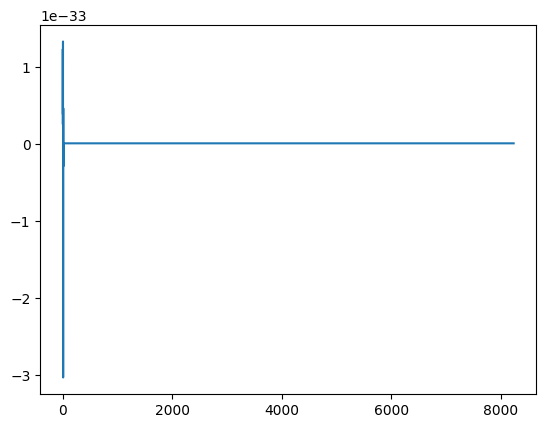

In [82]:
import matplotlib.pyplot as plt

plt.plot(solution[0,:-1], label='Hedging Weights')